# Imports

In [1]:
! pip install ffmpeg-python

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
from pathlib import Path

import ffmpeg
%matplotlib inline
import matplotlib.gridspec as gs
import matplotlib.pyplot as plt
import numpy as np
from scipy import signal
from scipy.fft import fftshift
from scipy.io import wavfile

# Задание 1

In [7]:
def plot_util(audio: list, audio_filtered: list, fs=44_100):
    gs0 = gs.GridSpec(2,2, width_ratios=[10, 0.1])
    fig = plt.figure(figsize=(10,5), dpi=150)
    ax1 = fig.add_subplot(gs0[0,0])
    ax1.set_title("Original")
    ax2 = fig.add_subplot(gs0[1,0])
    ax2.set_title("Filtered")
    cax = fig.add_subplot(gs0[:,1])

    spectrum1, freqs1, t1, im1 = ax1.specgram(audio, NFFT=1024, Fs=fs, noverlap=900)
    spectrum2, freqs2, t2, im2 = ax2.specgram(audio_filtered, NFFT=1024, Fs=fs, noverlap=900)

    fig.colorbar(im1, cax=cax)

In [3]:
FILE = '/content/The Smiths - Girlfriend In A Coma (dizer.net)'

In [4]:
# read file
in_file = f'{FILE}.mp3'
out_file = f"{FILE}.wav"
(
    ffmpeg
    .input(in_file)
    .output(out_file, acodec="pcm_s16le", ar="44100")
    .run(overwrite_output=True)
)

(None, None)

In [5]:
# обрезка аудио
in_file = f"{FILE}.wav"
out_file = f"{FILE}_cut.wav"

fs, audio = wavfile.read(in_file)
audio = audio[:, 0]
low = len(audio) // 4
high = 3 * len(audio) // 4 - 10 * fs
r = np.random.randint(low, high)
cut = audio[r:r + 10 * fs]
wavfile.write(f"{out_file}", fs, cut)

In [6]:
# фильтр Баттерворта
in_file = f"{FILE}_cut.wav"
out_file_wav = f"{FILE}_filtered.wav"

fs, audio = wavfile.read(in_file)

sos = signal.butter(10, 5000, btype="lowpass", analog=False, output="sos", fs=fs)
filtered = signal.sosfilt(sos, audio)
filtered /= np.max(filtered)

wavfile.write(out_file_wav, fs, filtered)

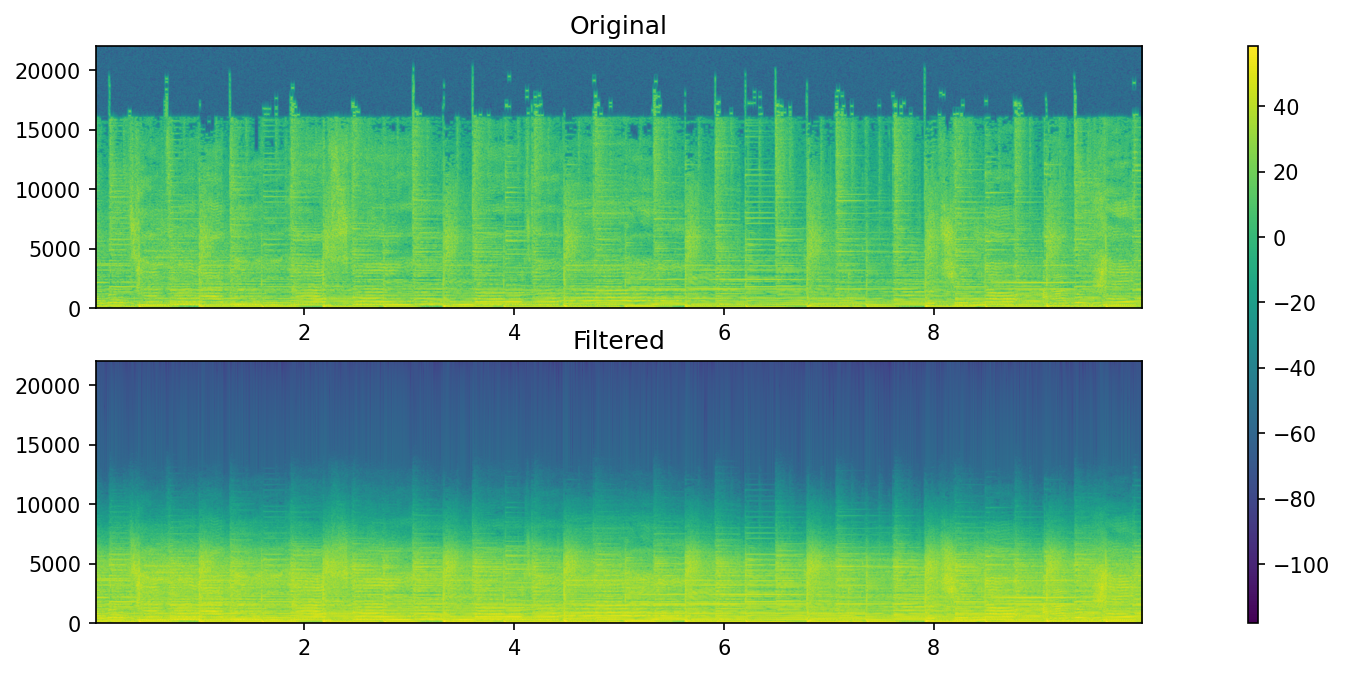

In [8]:
in_file = f"{FILE}_cut.wav"
in_file_filtered = f"{FILE}_filtered.wav"

fs, audio = wavfile.read(in_file)
_, audio_filtered = wavfile.read(in_file_filtered)

plot_util(audio, audio_filtered)

# Задание 2

Попробовал реализовать примерные кейсы с официального api signal, лучше, чем ничего

In [18]:
# фильтр Чебышева 1 рода
in_file = f"{FILE}_cut.wav"
out_file_wav = f"{FILE}_cheb1.wav"

fs, audio = wavfile.read(in_file)

sos = signal.cheby1(10, 1, 15, 'hp', fs=1000, output='sos')
filtered = signal.sosfilt(sos, audio)
filtered /= np.max(filtered)

wavfile.write(out_file_wav, fs, filtered)

In [19]:
# фильтр Чебышева 2 рода
in_file = f"{FILE}_cut.wav"
out_file_wav = f"{FILE}_cheb2.wav"

fs, audio = wavfile.read(in_file)

sos = signal.cheby2(12, 20, 17, 'hp', fs=1000, output='sos')
filtered = signal.sosfilt(sos, audio)
filtered /= np.max(filtered)

wavfile.write(out_file_wav, fs, filtered)

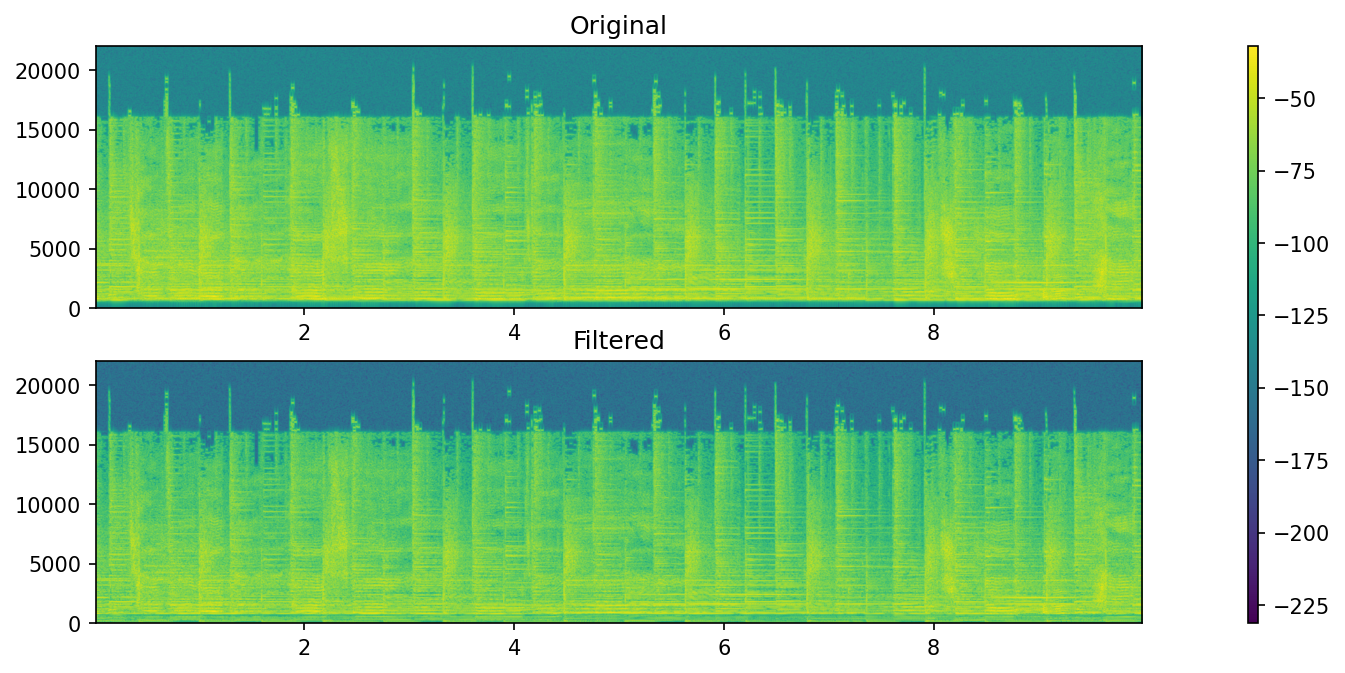

In [21]:
in_file1 = f"{FILE}_cheb1.wav"
in_file2 = f"{FILE}_cheb2.wav"

fs1, audio1 = wavfile.read(in_file1)
fs2, audio2 = wavfile.read(in_file2)

plot_util(audio1, audio2)

# Задание 3

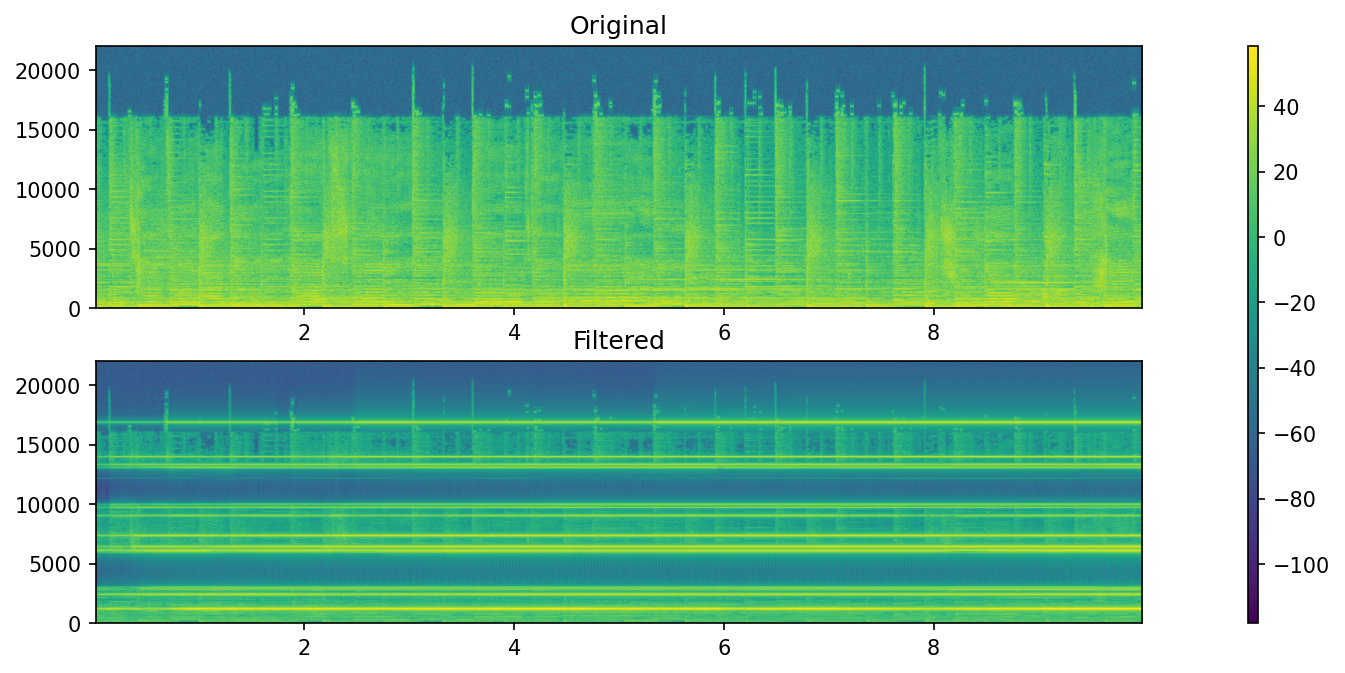

In [22]:
in_file = f"{FILE}_cut.wav"
out_file_wav = f"{FILE}_filtered_any.wav"

fs, audio = wavfile.read(in_file)

sos = signal.ellip(10, 1, 1, [3000, 6000], btype="bandstop", analog=False, output="sos", fs=fs)
f0 = signal.sosfilt(sos, audio)
sos = signal.ellip(10, 1, 1, [10000, 13000], btype="bandstop", analog=False, output="sos", fs=fs)
filtered = signal.sosfilt(sos, f0)

plot_util(audio, filtered)

# Задание 4

попробовал реализовать статью [link](https://dev.to/highcenburg/separate-vocals-from-a-track-using-python-4lb5)

In [23]:
import librosa
from librosa import display
import numpy as np
import IPython.display as ipd
import matplotlib as plt

In [25]:
y, sr = librosa.load(f'{FILE}.mp3')
ipd.Audio(data=y[90*sr:110*sr], rate=sr)

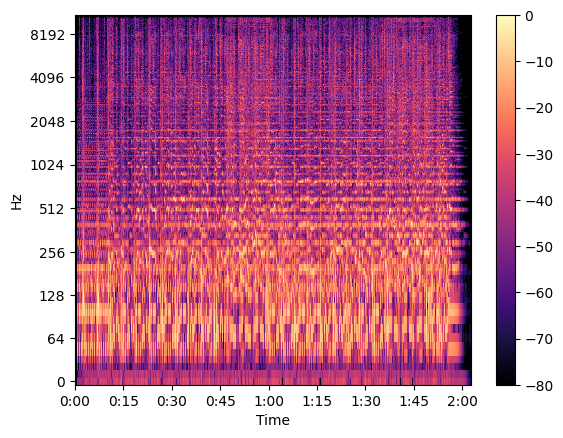

In [26]:
S_full, phase = librosa.magphase(librosa.stft(y)) # разделяем амплитуду и фазу трека, используя кратковременное преобразование Фурье
idx = slice(*librosa.time_to_frames([90*110], sr=sr)) # вырежем часть песни, а затем преобразовать ее в кадры stft
fig, ax = plt.pyplot.subplots() # чек спектрограмму 20-секундной части песни путем преобразования амплитудной спектрограммы в спектрограмму амплитуды в масштабе дБ
img = display.specshow(librosa.amplitude_to_db(S_full[:, idx], ref=np.max), y_axis='log', x_axis='time', sr=sr, ax=ax)
fig.colorbar(img, ax=ax)

In [27]:
# мы фильтруем вокал по его ближайшим соседям, агрегируем их медианные значения, сравниваем их кадры с помощью косинусного 
# сходства и держим эти кадры, разделенные на 2 секунды, и подавляем другие звуки из спектра
S_filter = librosa.decompose.nn_filter(S_full, aggregate=np.median, metric='cosine', width=int(librosa.time_to_frames(2, sr=sr)))
S_filter = np.minimum(S_full, S_filter)

In [28]:
margin_i, margin_v = 3, 11
power = 3

mask_i = librosa.util.softmask(S_filter, margin_i * (S_full - S_filter), power=power)
mask_v = librosa.util.softmask(S_full - S_filter, margin_v * S_filter, power=power)

S_foreground = mask_v * S_full
S_background = mask_i * S_full

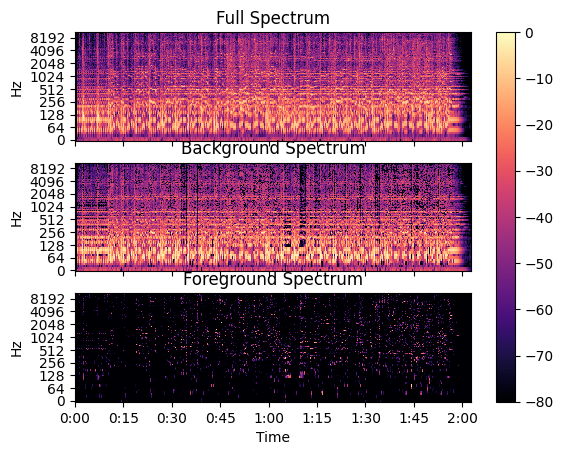

In [29]:
fig, ax = plt.pyplot.subplots(nrows=3, sharex=True, sharey=True)
img = display.specshow(librosa.amplitude_to_db(S_full[:, idx], ref=np.max), y_axis='log', x_axis='time', sr=sr, ax=ax[0])
ax[0].set(title='Full Spectrum')
ax[0].label_outer()

display.specshow(librosa.amplitude_to_db(S_background[:, idx], ref=np.max), y_axis='log', x_axis='time', sr=sr, ax=ax[1])
ax[1].set(title='Background Spectrum')
ax[1].label_outer()

display.specshow(librosa.amplitude_to_db(S_foreground[:, idx], ref=np.max), y_axis='log', x_axis='time', sr=sr, ax=ax[2])
ax[2].set(title='Foreground Spectrum')
ax[2].label_outer()

fig.colorbar(img, ax=ax)